## EDAコードのコピー(1)
    
    * https://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline

【アクションアイテム】
* カーネル密度推定って結局なんなん？

In [1]:
#DATA = "../../KAGGLE_DATA/amex-default-prediction"
DATA = "/mnt/sdb/KAGGLE_DATA/amex-default-prediction"
PICKLE = "_pickle"

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

import warnings, gc; warnings.filterwarnings("ignore")

temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), height=500, width=1000))

train = pd.read_pickle(os.path.join(DATA, PICKLE, "train_data.pkl"))
test = pd.read_pickle(os.path.join(DATA, PICKLE, "test_data.pkl"))

target = pd.read_pickle(os.path.join(DATA, PICKLE, "train_labels.pkl"))

train = pd.merge(train, target, on="customer_ID", how="left")

* 顧客ごとに長さの異なる時系列テーブルがあること
* 未来を予測するので、一般にデータの中の最新レコードが一番参考になりそうだということ

=> 一旦train, testの最後尾だけに持ち替えている

In [3]:
train = train.groupby("customer_ID").tail(1).set_index("customer_ID")
print("The training data begins on {} and ends on {}.".format(train["S_2"].min(), train["S_2"].max()))
print("There are {:,.0f} customers in the training set and {} features.".format(train.shape[0], train.shape[1]))

test = test.groupby("customer_ID").tail(1).set_index("customer_ID")
print("The test data begins on {} and ends on {}.".format(test["S_2"].min(), test["S_2"].max()))
print("There are {:,.0f} customers in the test set and {} features.".format(test.shape[0], test.shape[1]))


The training data begins on 2018-03-01 and ends on 2018-03-31.
There are 458,913 customers in the training set and 190 features.
The test data begins on 2019-04-01 and ends on 2019-10-31.
There are 924,621 customers in the test set and 189 features.


In [4]:
temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), height=500, width=1000))

## TrainのTargetの値の分布の確認

In [5]:
target = train["target"].value_counts(normalize=True)
target.rename(index={1: "Default", 0:"Paid"}, inplace=True)

display(target)

pal, color=["#016CC9", "#DEB078"], ["#8DBAE2", "#EDD3B3"]
fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=target.index,
        values=target*100,
        hole=.45,
        showlegend=True,
        sort=False,
        marker=dict(colors=color, line=dict(color=pal, width=2.5)),
        hovertemplate= "%{label} Accounts: %{value:.2f}%<extra></extra>"
        )
    )
fig.update_layout(
    template=temp,
    title="Target Distribution",
    legend=dict(traceorder="reversed", y=1.05, x=0),
    uniformtext_minsize=15,
    uniformtext_mode="hide",
    width=700)

Paid       0.741066
Default    0.258934
Name: target, dtype: float64

## 日ごとの滞納者の割合
* そもそも「各customer_IDの最後尾を取ってこのグラフ書くことに意味がある」と思えない気がした・・・
    * そういう訓練だから頑張ろう。

* 観点としては、「時系列だから週・月のトレンドがあるのでは？」という観点だと思う
    * a weekly seasonal trend in the day of the month と書かれていた


In [6]:
target = pd.DataFrame(data={"Default":train.groupby("S_2")["target"].mean()*100})
target["Paid"] = np.abs(train.groupby("S_2")["target"].mean()-1)*100

rgb = ["rgba"+str(matplotlib.colors.to_rgba(i, 0.7)) for i in pal]
fig = go.Figure()
fig.add_trace(go.Bar(
        x=target.index, y=target.Paid,
        name="Paid", text=target.Paid,
        texttemplate="%{text:.0f}%",
        textposition="inside", insidetextanchor="middle",
        marker=dict(color=color[0], line=dict(color=pal[0], width=1.5)),
        hovertemplate = "<b>%{x}</b><br>Paid accounts: %{y:.2f}%")
    )
fig.add_trace(go.Bar(
        x=target.index, y=target.Default,
        name="Default", text=target.Default,
        texttemplate="%{text:.0f}%",
        textposition="inside", insidetextanchor="middle",
        marker=dict(color=color[1], line=dict(color=pal[1], width=1.5)),
        hovertemplate = "<b>%{x}</b><br>Default accounts: %{y:.2f}%")
    )

fig.update_layout(
    template=temp, title="Distribution of Default by Day",
    barmode="relative", yaxis_ticksuffix="%", width=1400,
    legend=dict(orientation="h", traceorder="reversed", yanchor="bottom", y=1.1, xanchor="left", x=0)
)
fig.show()

## 日ごとのcustome_IDのunique数

In [7]:
plot_df = train.reset_index().groupby("S_2")["customer_ID"].nunique().reset_index()
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=plot_df["S_2"], y=plot_df["customer_ID"],
    mode="lines", line=dict(color=pal[0], width=3),
    hovertemplate=""
))
fig.update_layout(
    template=temp, title="Frequency of Customer Statements",
    hovermode="x unified", width=800, height=500,
    xaxis_title="Statement Date", yaxis_title="Number of Statements Issued"
)
fig.show()

## Targetごと、Delinquency (D_###)の分布（カーネル密度推定） --

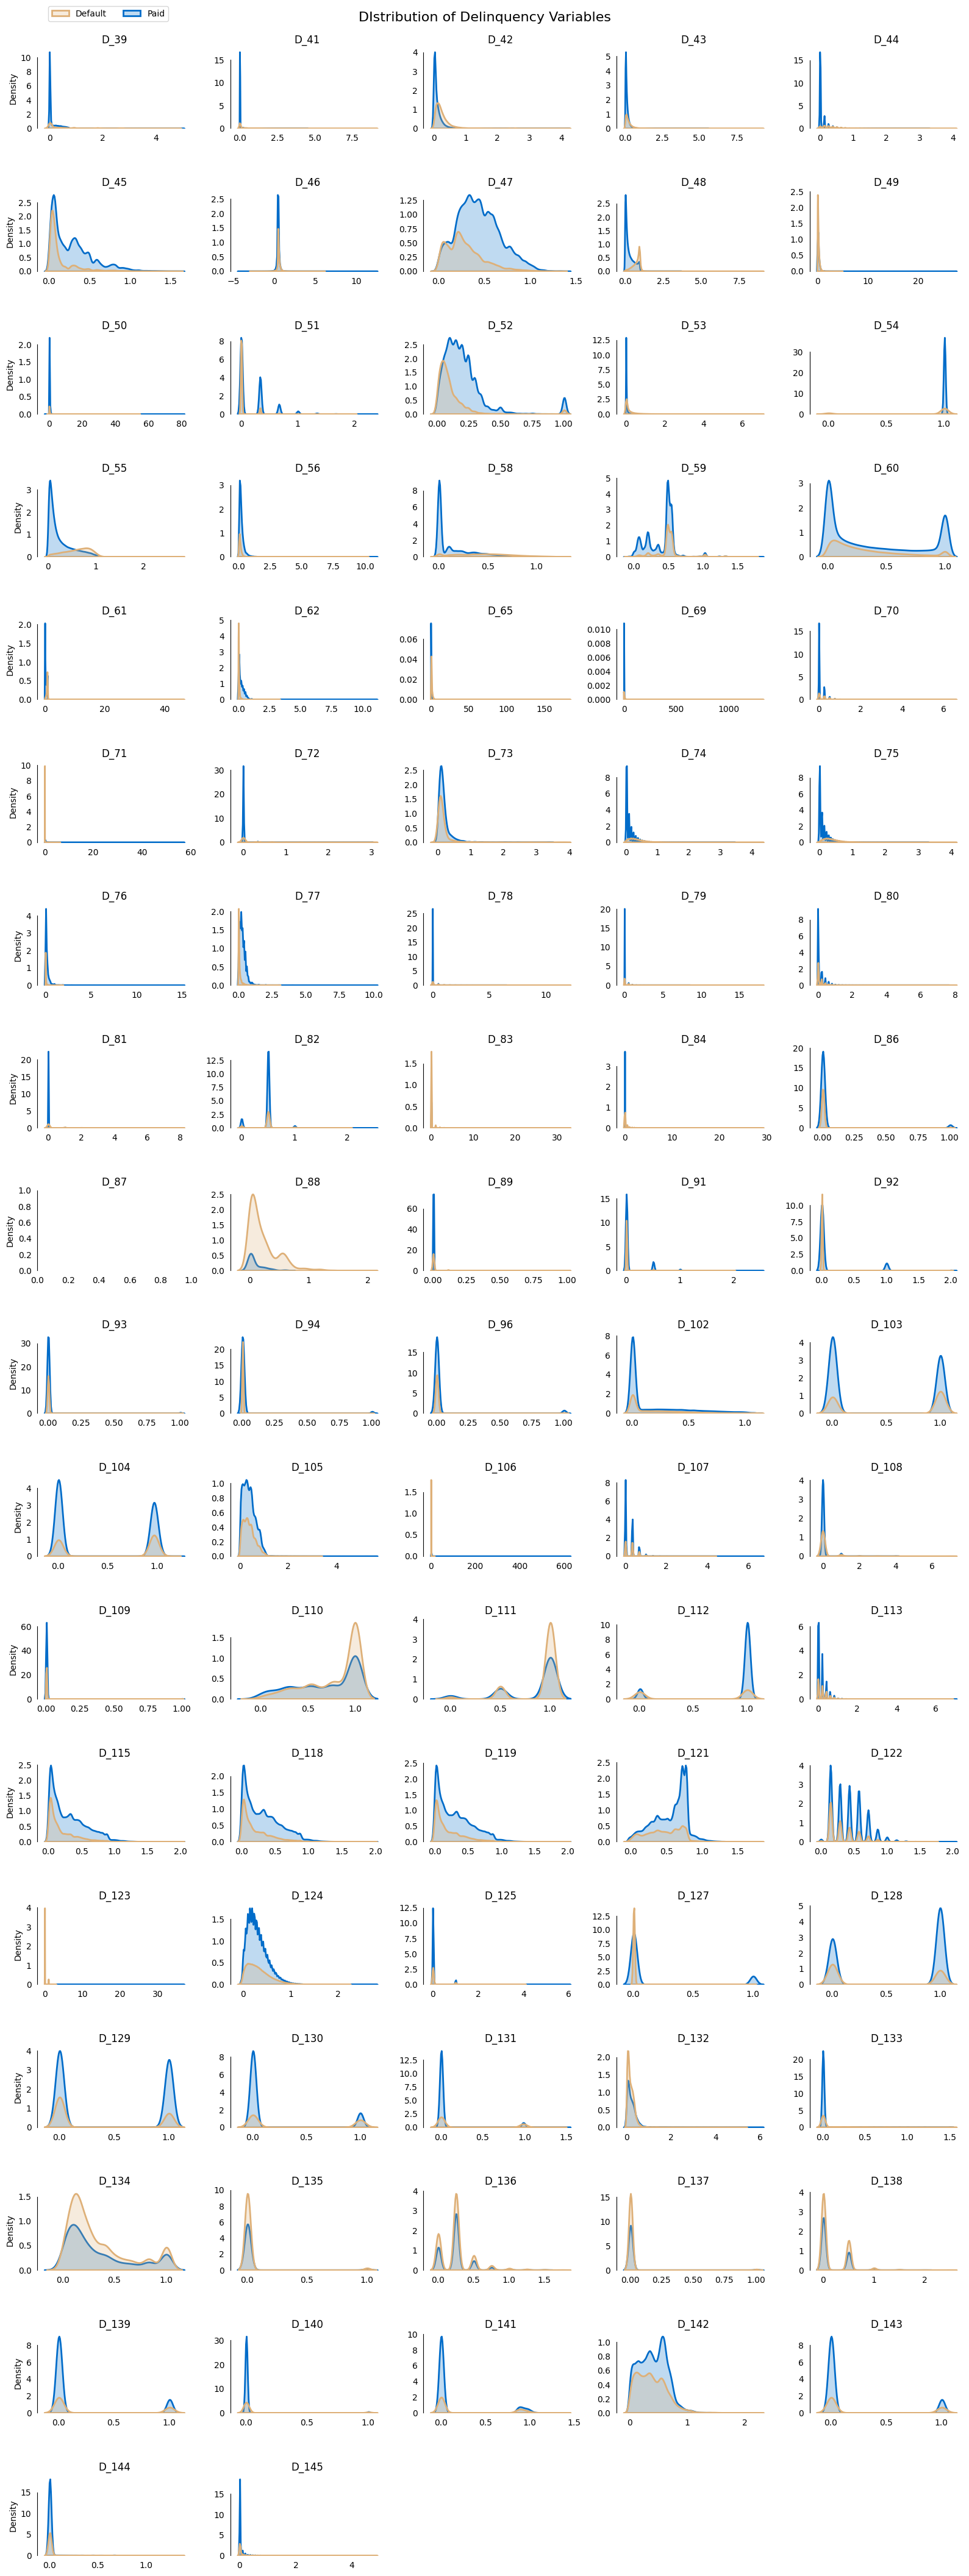

In [8]:
cat_cols = ["B_30", "B_38", "D_63", "D_64", "D_66", "D_68", "D_114", "D_116", "D_117", "D_120", "D_126", "target"]
cols=[col for col in train.columns if ((col.startswith(('D','T'))) & (col not in cat_cols[:-1])) or (col == "target")]
plot_df = train[cols]

fig, ax = plt.subplots(18, 5, figsize=(16, 54))
fig.suptitle("DIstribution of Delinquency Variables", fontsize=16)

row = 0
col = [0, 1, 2 ,3, 4]*18

for i, column in enumerate(plot_df.columns[:-1]):
    if (i != 0) & (i%5 == 0):
        row += 1
    sns.kdeplot(
        x=column, hue="target", palette=pal[::-1], hue_order=[1, 0],
        label=["Default", "Paid"], data=plot_df,
        fill=True, linewidth=2, legend=False, ax=ax[row, col[i]]
    )
    ax[row, col[i]].tick_params(left=False, bottom=False)
    ax[row, col[i]].set(title="\n\n{}".format(column), xlabel="", ylabel=("Density" if i%5==0 else ""))

for i in range(2, 5):
    ax[17, i].set_visible(False)
handles, _ = ax[0, 0].get_legend_handles_labels()
fig.legend(labels=["Default", "Paid"], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.983))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

## Delinquency(D_###)について、相関係数行列

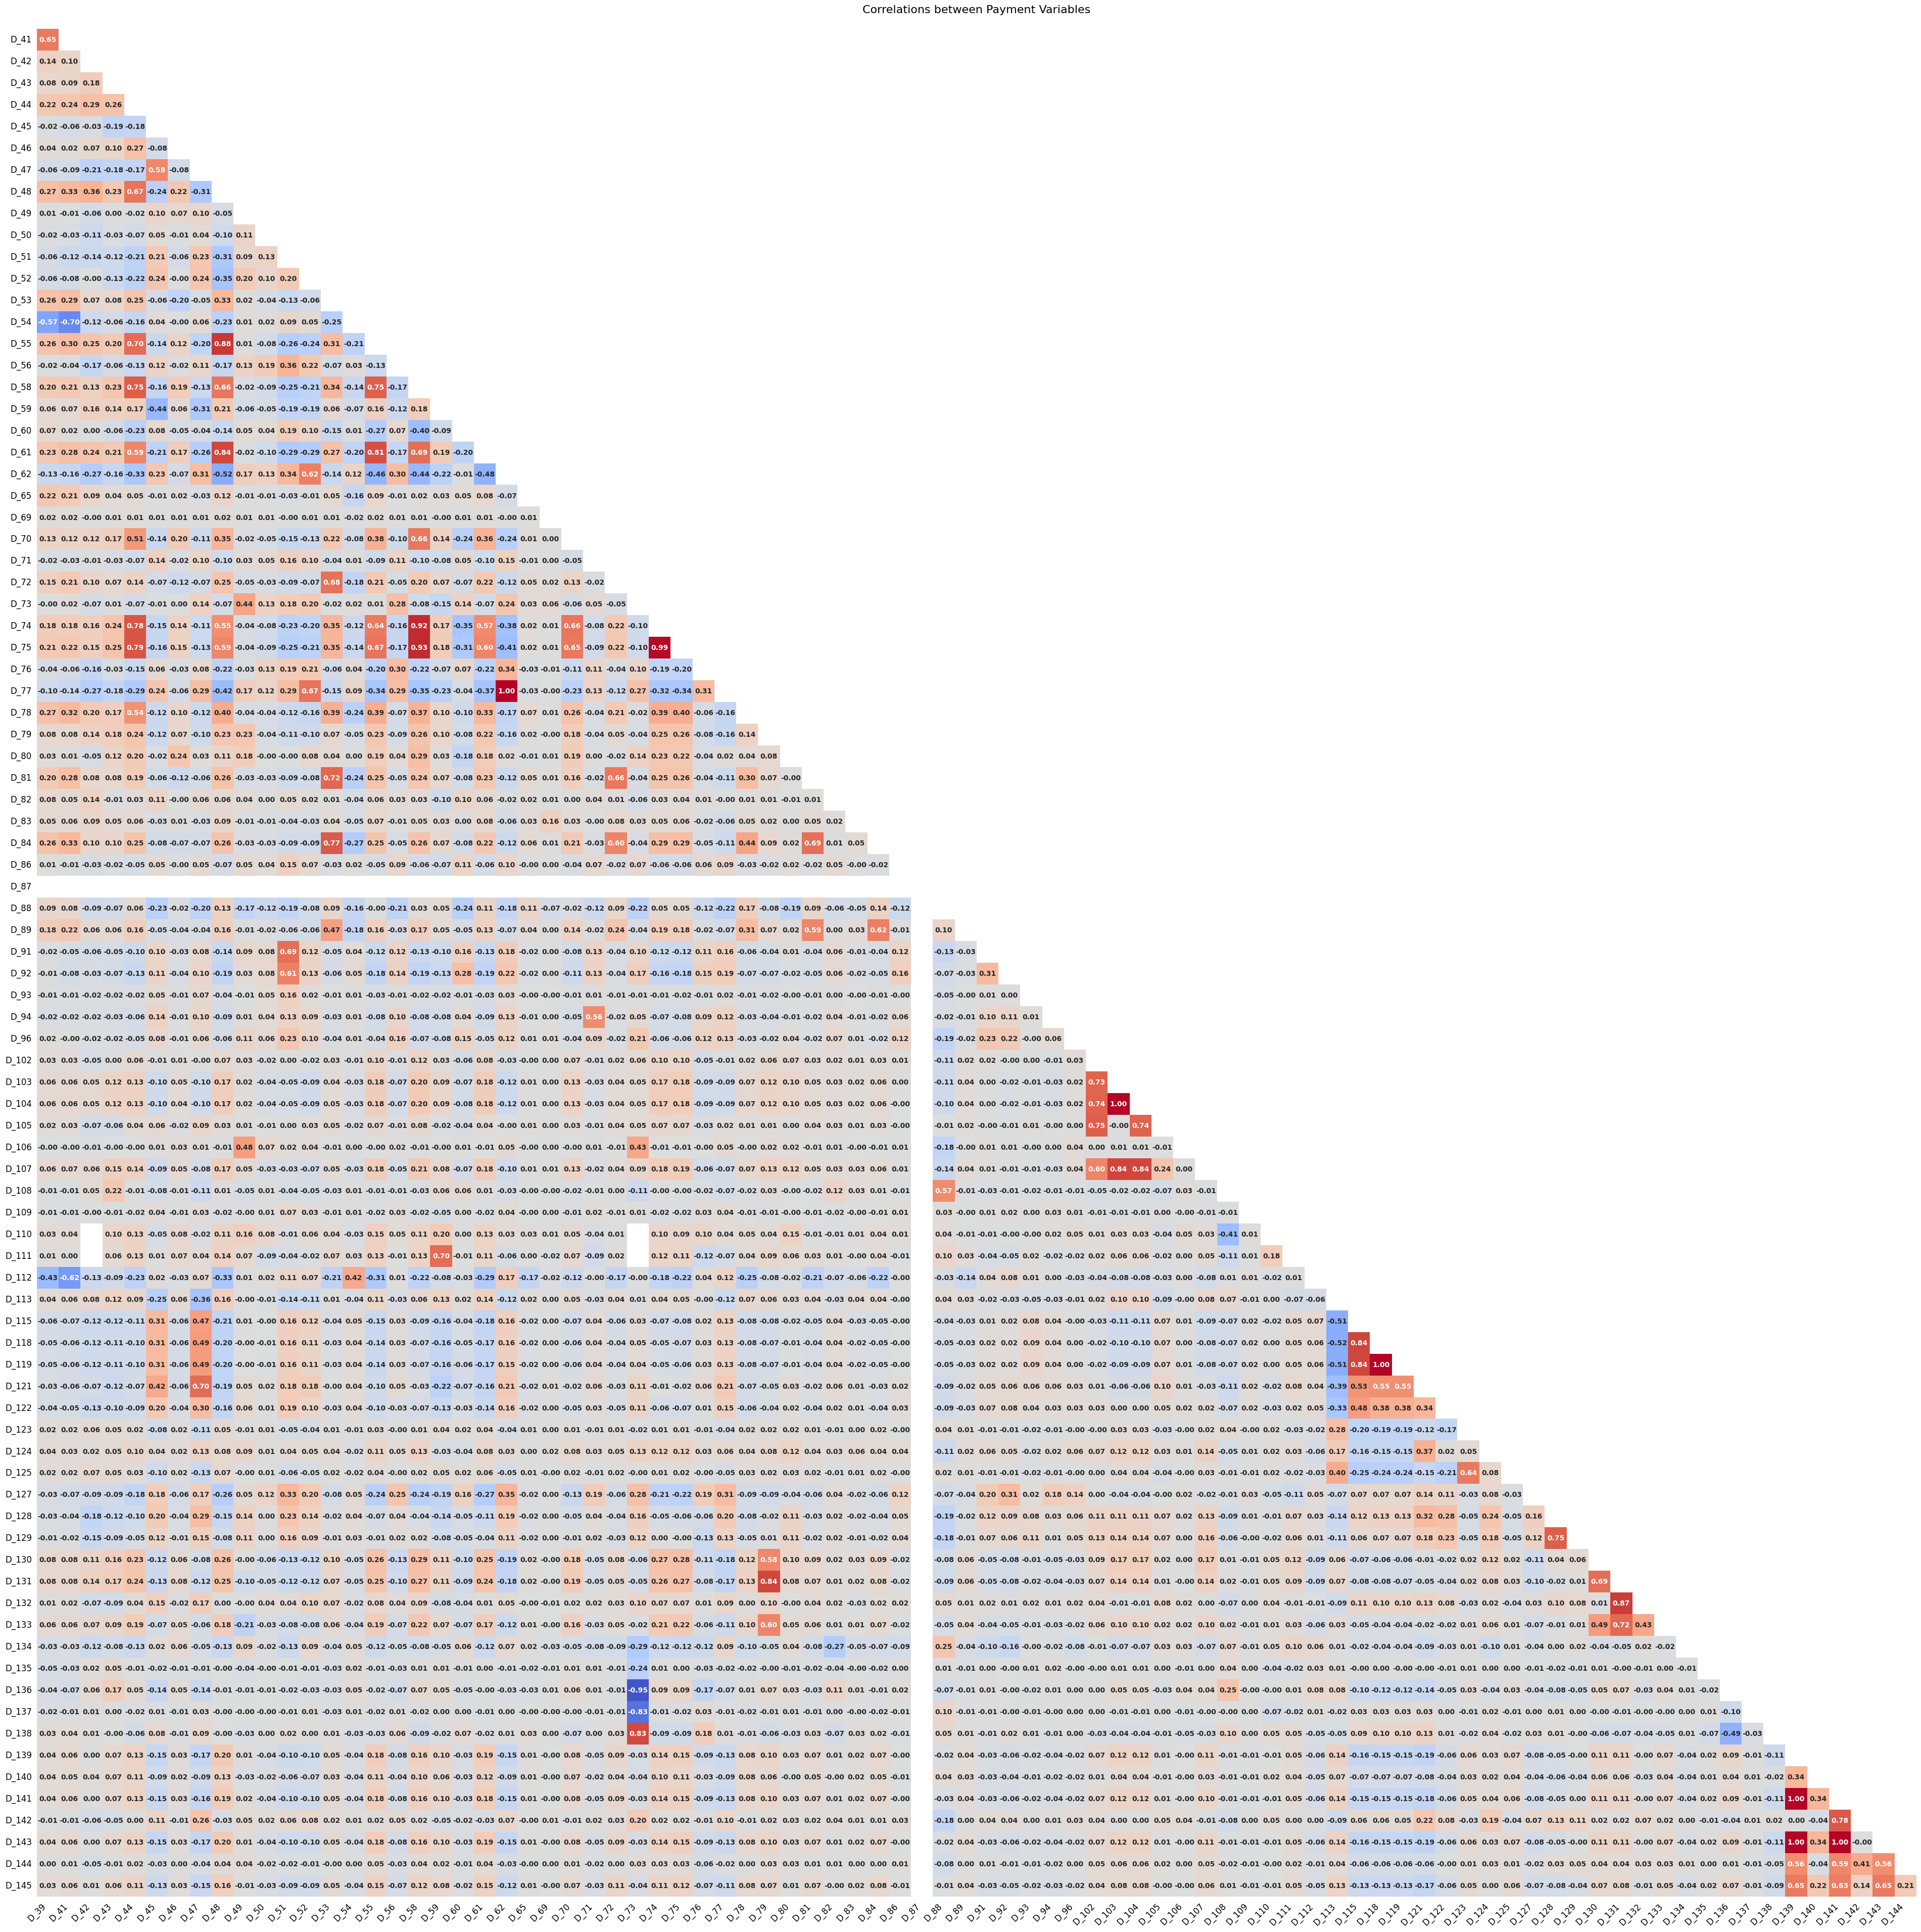

In [9]:
corr = plot_df.iloc[:, :-1].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()

fig, ax = plt.subplots(figsize=(48, 48))
sns.heatmap(
    corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt=".2f",
    cmap="coolwarm", annot_kws={"fontsize":10, "fontweight":"bold"}, cbar=False
)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right", fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title("Correlations between Payment Variables\n", fontsize=16)
fig.show()

* いくつかの変数で極端に高い相関係数
* うち、いくつかはcorr=1となっているので注意
* D_87はNullが顕著

## 極端に高いやつについて散布図で個別に確認
* scatterだと重なって見えなくなるのがhexbinだとcmapで表現される（ということだと思う）
* log-transformedはカラーマップが対数変換されてる

Text(1.1, 5.9, 'Correlation: 0.87')

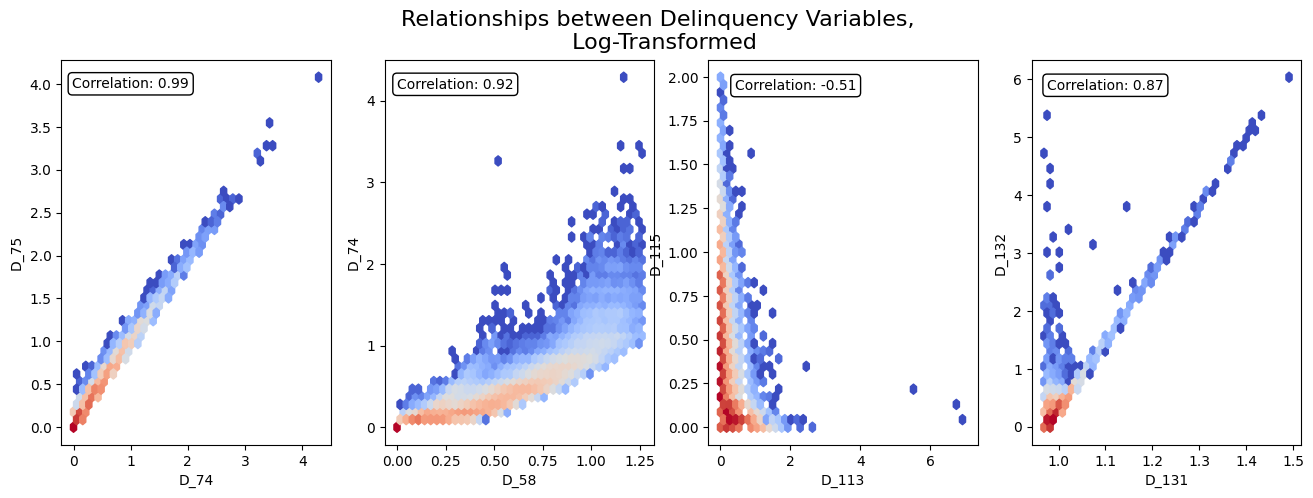

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
fig.suptitle("Relationships between Delinquency Variables, \n Log-Transformed", fontsize=16)

ax[0].hexbin(x="D_74", y="D_75", data=plot_df, bins="log", gridsize=40, cmap="coolwarm")
ax[0].set(xlabel="D_74", ylabel="D_75")
ax[0].text(
    1, 4, 
    "Correlation: {:.2f}".format(plot_df[["D_74", "D_75"]].corr().iloc[1, 0]),
    ha="center", va="center", bbox=dict(boxstyle="round, pad=0.3", fc="white")
    )

ax[1].hexbin(x="D_58", y="D_74", data=plot_df, bins="log", gridsize=40, cmap="coolwarm")
ax[1].set(xlabel="D_58", ylabel="D_74")
ax[1].text(
    0.3, 4.2, 
    "Correlation: {:.2f}".format(plot_df[["D_58", "D_74"]].corr().iloc[1, 0]),
    ha="center", va="center", bbox=dict(boxstyle="round, pad=0.3", fc="white")
    )

ax[2].hexbin(x="D_113", y="D_115", data=plot_df, bins="log", gridsize=40, cmap="coolwarm")
ax[2].set(xlabel="D_113", ylabel="D_115")
ax[2].text(
    2.15, 1.95, 
    "Correlation: {:.2f}".format(plot_df[["D_113", "D_115"]].corr().iloc[1, 0]),
    ha="center", va="center", bbox=dict(boxstyle="round, pad=0.3", fc="white")
    )

ax[3].hexbin(x="D_131", y="D_132", data=plot_df, bins="log", gridsize=40, cmap="coolwarm")
ax[3].set(xlabel="D_131", ylabel="D_132")
ax[3].text(
    1.1, 5.9, 
    "Correlation: {:.2f}".format(plot_df[["D_131", "D_132"]].corr().iloc[1, 0]),
    ha="center", va="center", bbox=dict(boxstyle="round, pad=0.3", fc="white")
    )

## Spend(S_###)について、Targetごとの分布

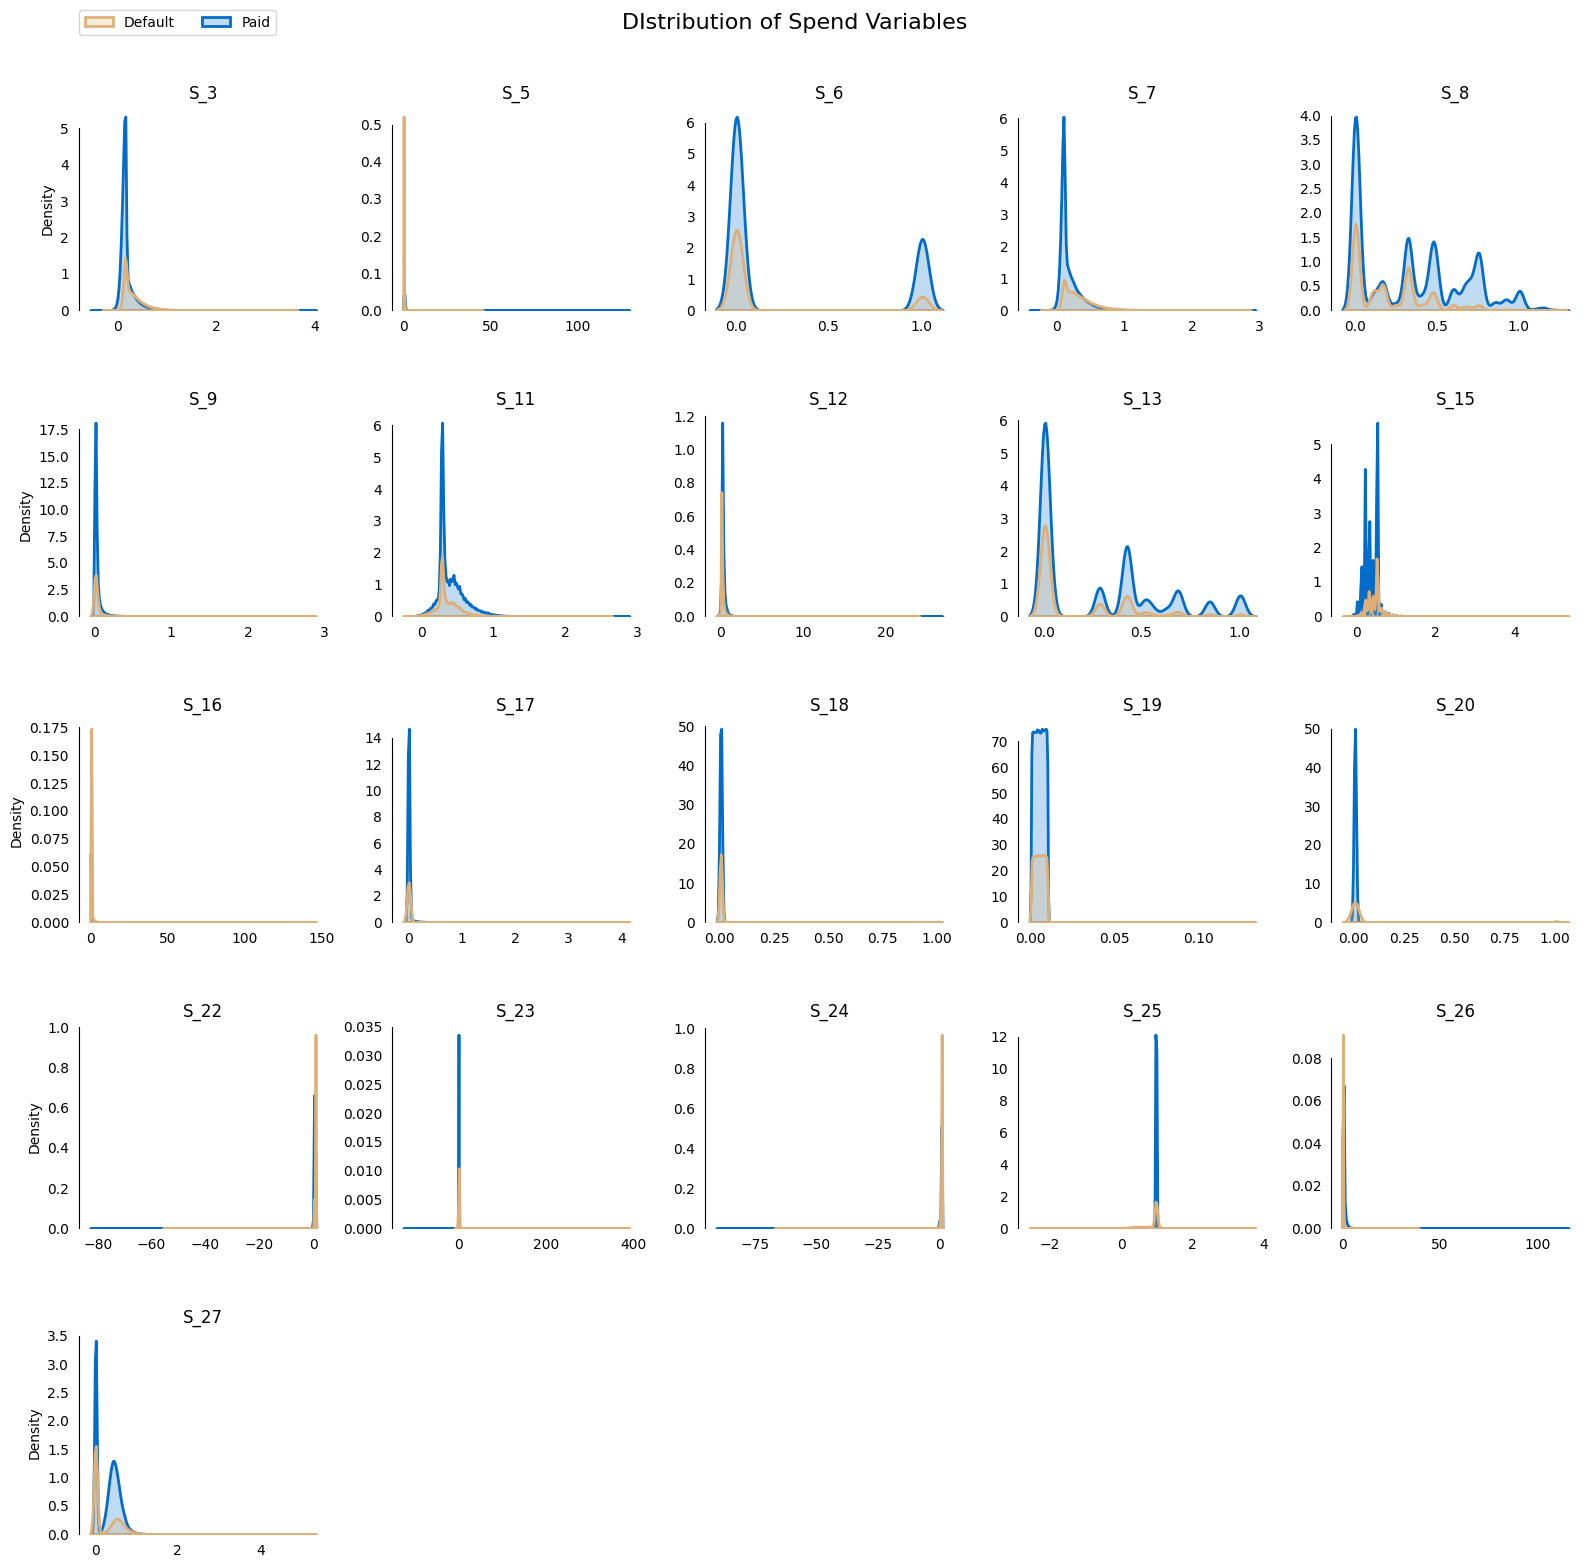

In [11]:
cols=[col for col in train.columns if ((col.startswith(('S','T'))) & (col not in cat_cols[:-1])) or (col == "target")]
plot_df = train[cols]

plot_df = plot_df.drop("S_2", axis=1)


fig, ax = plt.subplots(5, 5, figsize=(16, 20))
fig.suptitle("DIstribution of Spend Variables", fontsize=16)

row = 0
col = [0, 1, 2 ,3, 4]*18

for i, column in enumerate(plot_df.columns[:-1]):
    if (i != 0) & (i%5 == 0):
        row += 1
    sns.kdeplot(
        x=column, hue="target", palette=pal[::-1], hue_order=[1, 0],
        label=["Default", "Paid"], data=plot_df,
        fill=True, linewidth=2, legend=False, ax=ax[row, col[i]]
    )
    ax[row, col[i]].tick_params(left=False, bottom=False)
    ax[row, col[i]].set(title="\n\n{}".format(column), xlabel="", ylabel=("Density" if i%5==0 else ""))

for i in range(1, 5):
    ax[4, i].set_visible(False)
handles, _ = ax[0, 0].get_legend_handles_labels()
fig.legend(labels=["Default", "Paid"], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.985))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

## Spendについて相関係数行列 --

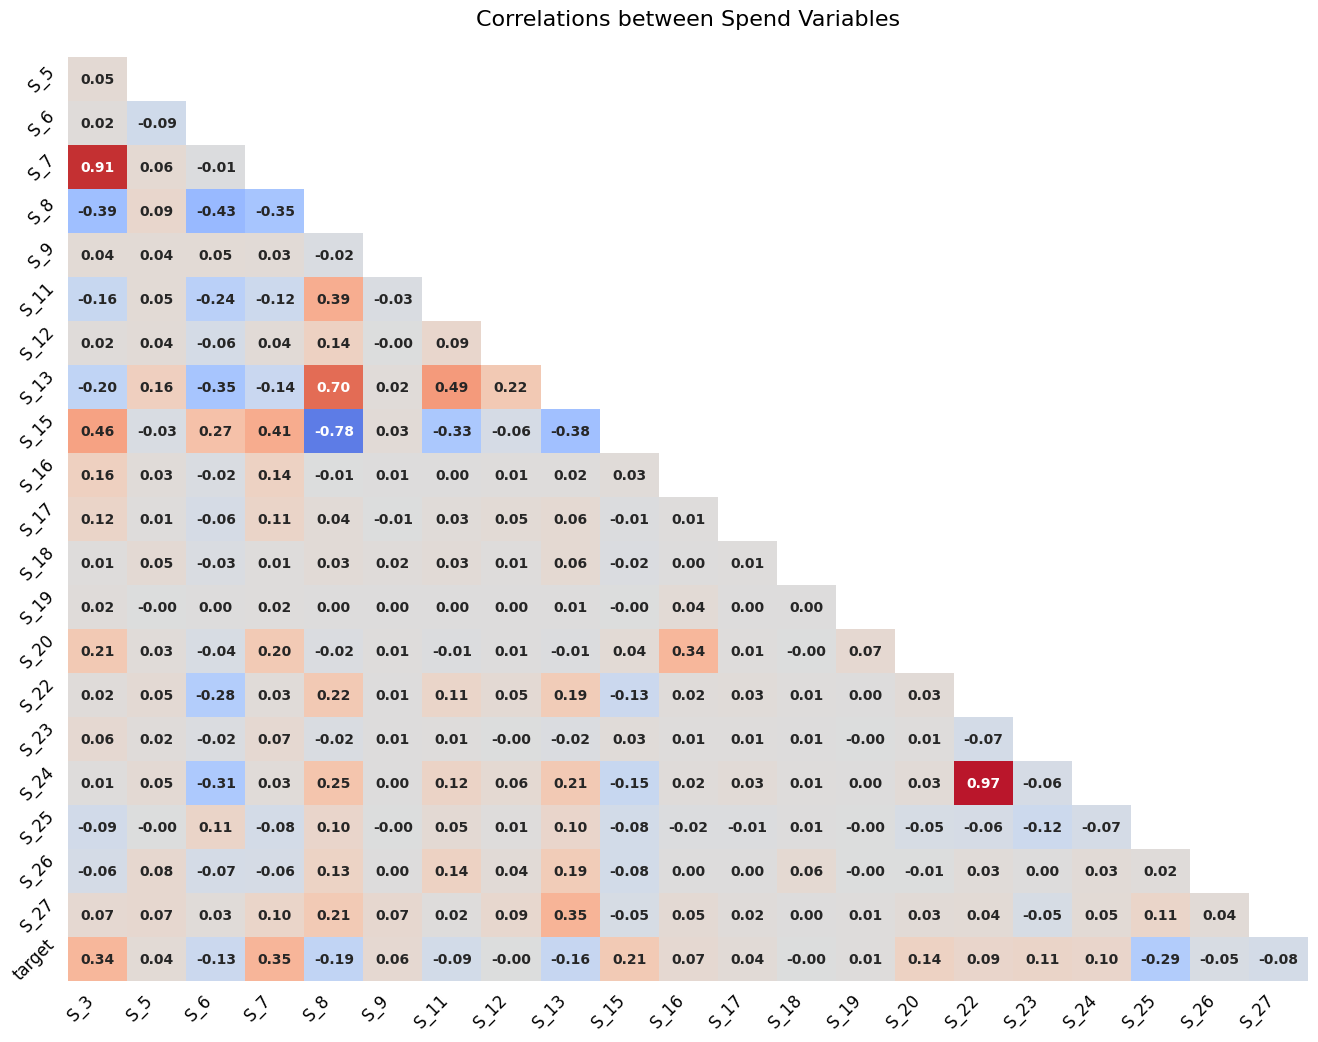

In [12]:
corr = plot_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()

fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(
    corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt=".2f",
    cmap="coolwarm", annot_kws={"fontsize":10, "fontweight":"bold"}, cbar=False)

ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right", fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, fontsize=12)
plt.title("Correlations between Spend Variables\n ", fontsize=16)
fig.show()

## 特に目立つ例について更に可視化 --

Text(0.5, 5.5, 'Correlation: -0.33')

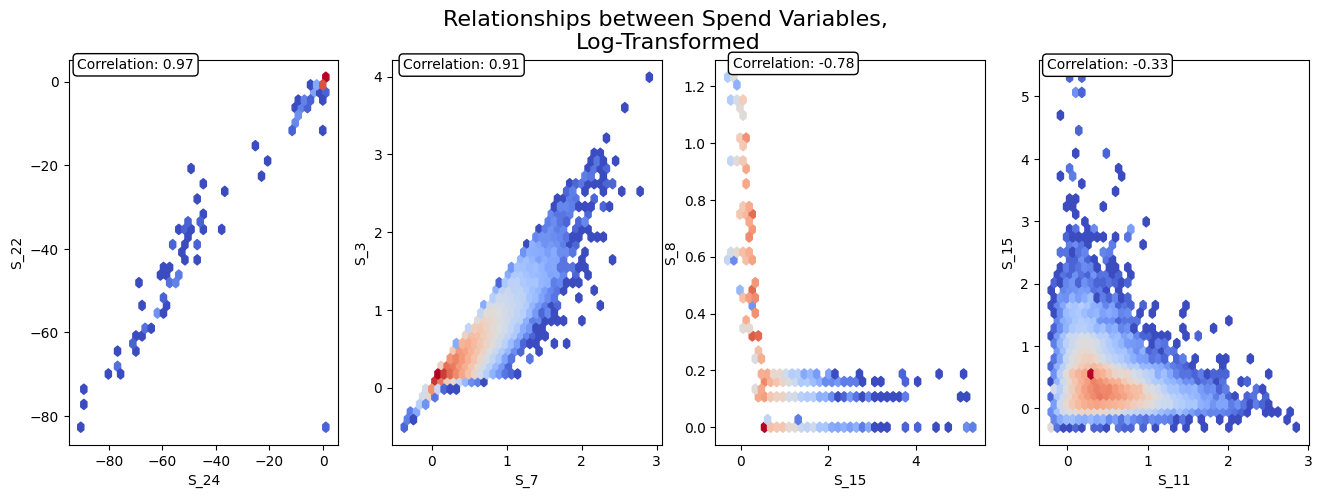

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
fig.suptitle("Relationships between Spend Variables, \nLog-Transformed", fontsize=16)
ax[0].hexbin(x="S_24", y="S_22", data=plot_df, bins="log", gridsize=40, cmap="coolwarm")
ax[0].set(xlabel="S_24", ylabel="S_22")
ax[0].text(
    -70, 4, "Correlation: {:.2f}".format(plot_df[["S_24", "S_22"]].corr().iloc[1, 0]),
    ha="center", va="center", bbox=dict(boxstyle="round, pad=0.3", fc="white")
)

ax[1].hexbin(x="S_7", y="S_3", data=plot_df, bins="log", gridsize=40, cmap="coolwarm")
ax[1].set(xlabel="S_7", ylabel="S_3")
ax[1].text(
    0.4, 4.15, "Correlation: {:.2f}".format(plot_df[["S_7", "S_3"]].corr().iloc[1, 0]),
    ha="center", va="center", bbox=dict(boxstyle="round, pad=0.3", fc="white")
)

ax[2].hexbin(x="S_15", y="S_8", data=plot_df, bins="log", gridsize=40, cmap="coolwarm")
ax[2].set(xlabel="S_15", ylabel="S_8")
ax[2].text(
    1.2, 1.28, "Correlation: {:.2f}".format(plot_df[["S_15", "S_8"]].corr().iloc[1, 0]),
    ha="center", va="center", bbox=dict(boxstyle="round, pad=0.3", fc="white")
)

ax[3].hexbin(x="S_11", y="S_15", data=plot_df, bins="log", gridsize=40, cmap="coolwarm")
ax[3].set(xlabel="S_11", ylabel="S_15")
ax[3].text(
    0.5, 5.5, "Correlation: {:.2f}".format(plot_df[["S_11", "S_15"]].corr().iloc[1, 0]),
    ha="center", va="center", bbox=dict(boxstyle="round, pad=0.3", fc="white")
)




## Payment(P_##)について同様

* ここまでと同様 --

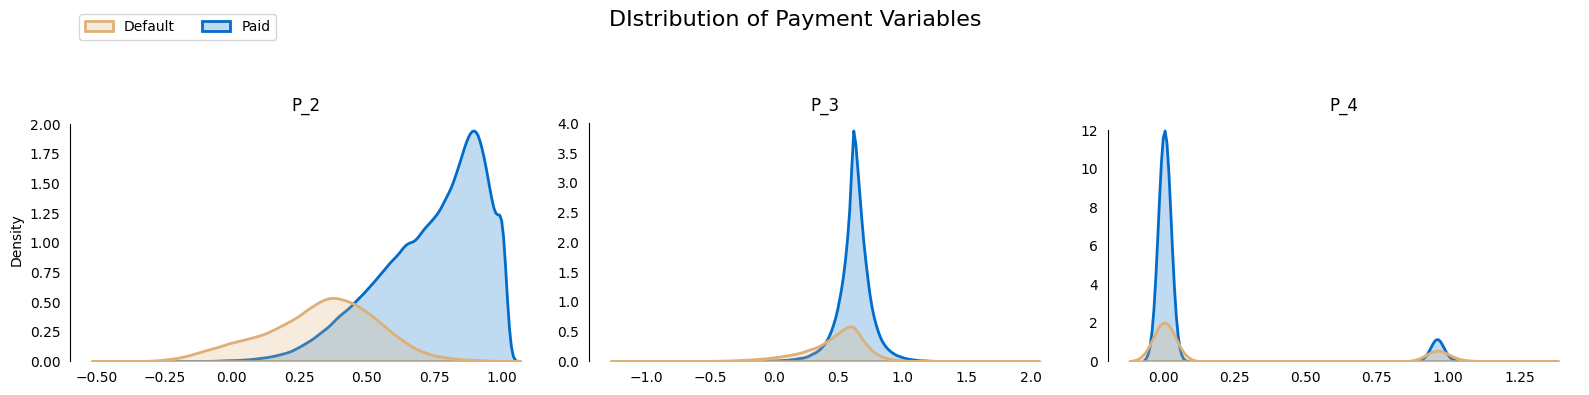

In [14]:
cols=[col for col in train.columns if ((col.startswith(('P','T'))) & (col not in cat_cols[:-1])) or (col == "target")]
plot_df = train[cols]

fig, ax = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("DIstribution of Payment Variables", fontsize=16)

for i, column in enumerate(plot_df.columns[:-1]):
    sns.kdeplot(
        x=column, hue="target", palette=pal[::-1], hue_order=[1, 0],
        label=["Default", "Paid"], data=plot_df,
        fill=True, linewidth=2, legend=False, ax=ax[i]
    )
    ax[i].tick_params(left=False, bottom=False)
    ax[i].set(title="\n\n{}".format(column), xlabel="", ylabel=("Density" if i%5==0 else ""))

handles, _ = ax[0].get_legend_handles_labels()
fig.legend(labels=["Default", "Paid"], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.985))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

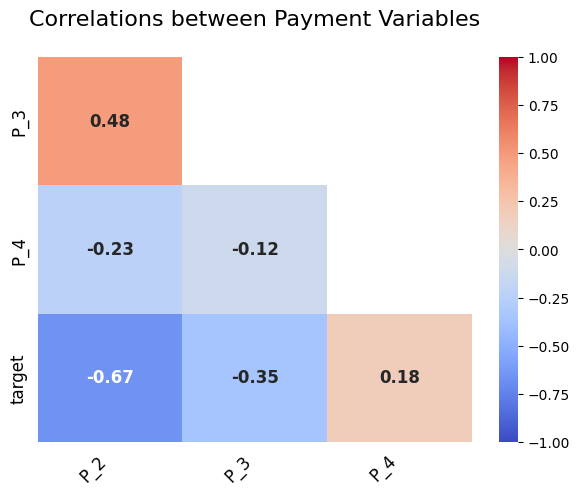

In [15]:
corr = plot_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()

fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(
    corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt=".2f",
    cmap="coolwarm", annot_kws={"fontsize":12, "fontweight":"bold"}
)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right", fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title("Correlations between Payment Variables\n", fontsize=16)
fig.show()

## Balance(B_###)について同様

## カテゴリ変数に関して、カテゴリの値ごとにtargetの値の差 --
* PaidとDefault逆じゃない？--
    * 逆じゃないです。1が破産

In [16]:
fig = make_subplots(
    rows=4, cols=3, subplot_titles=cat_cols[:-1],
    vertical_spacing=0.1
)
row = 0
c = [1, 2, 3]*5
plot_df = train[cat_cols]

for i, col in enumerate(cat_cols[:-1]):
    if i%3 == 0:
        row += 1
    plot_df[col] = plot_df[col].astype(object)
    df = plot_df.groupby(col)["target"].value_counts().rename("count").reset_index().replace("", np.nan)

    fig.add_trace(
        go.Bar(
            x=df[df.target==1][col], y=df[df.target==1]["count"],
            marker_color=rgb[1], marker_line=dict(color=pal[1], width=2),
            hovertemplate="Value %{x} Frequency = %{y}",
            name="Default", showlegend=(True if i==0 else False)
            ),
        row=row, col=c[i]
        )

    fig.add_trace(
        go.Bar(
            x=df[df.target==0][col], y=df[df.target==0]["count"],
            marker_color=rgb[0], marker_line=dict(color=pal[0], width=2),
            hovertemplate="Value %{x} Frequency = %{y}",
            name="Paid", showlegend=(True if i==0 else False)
            ),
        row=row, col=c[i]
        )

    if i%3 == 0:
        fig.update_yaxes(title="Frequency", row=row, col=c[i])

fig.update_layout(
    template=temp, title="Distribution of Categorical Variables",
    legend=dict(orientation="h", yanchor="bottom", y=1.03, xanchor="right", x=0.2),
    barmode="group", height=1500, width=900
)



fig.show()

## カテゴリ変数とtargetの相関、変数同士の相関係数が定義されないのでこういう形になる

In [17]:
corr = train.corr()
corr = corr["target"].sort_values(ascending=False)[1:-1]
pal = sns.color_palette("Reds_r", 135).as_hex()
rgb = ["rgba" + str(matplotlib.colors.to_rgba(i, 0.7)) for i in pal]

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=corr[corr>=0], y=corr[corr>=0].index,
        marker_color=rgb, orientation="h",
        marker_line=dict(color=pal, width=2), name="",
        hovertemplate="%{y} correlation with target: %{x:.3d}",
        showlegend=False
    )
)
pal = sns.color_palette("Blues", 100).as_hex()

rgb = ["rgba" + str(matplotlib.colors.to_rgba(i, 0.7)) for i in pal]
fig.add_trace(
    go.Bar(
        x=corr[corr<0], y=corr[corr<0].index,
        marker_color=rgb[25:], orientation="h",
        marker_line=dict(color=pal[25:], width=2), name="",
        hovertemplate="%{y} correlation with target: %{x:.3f}",
        showlegend=False
    )
)

fig.update_layout(
    template=temp, title="Feature Correlations with Target",
    xaxis_title="Correlation", margin=dict(l=150),
    height=3000, width=700, hovermode="closest"
)
fig.show()


## 数値・カテゴリ問わず欠損の確認 --

In [18]:
null = round((train.isna().sum()/train.shape[0]*100), 2).sort_values(ascending=False).astype(str) + ("%")
null = null.to_frame().rename(columns={0: "Missing %"})
null.head(30)

Missing %
D_87     99.86%
D_88     99.82%
D_108    99.43%
D_110     99.2%
D_111     99.2%
B_39     99.11%
D_73     99.08%
B_42     98.66%
D_136    96.43%
D_138    96.43%
D_135    96.43%
D_134    96.43%
D_137    96.43%
R_9      94.13%
B_29     94.05%
D_76     89.25%
R_26     88.86%
D_106    88.75%
D_49     88.72%
D_132    88.72%
D_66     88.54%
D_42     86.95%
D_142     82.5%
D_82     74.81%
D_53     71.02%
D_50     57.14%
D_105    53.52%
D_56     53.33%
B_17     53.27%
D_77      46.6%

## ベースラインの作成
* 「欠損が多い」「外れ値がある」ことがわかったので、lightgbmで行きます
* targetの分布も均等じゃないのでStratified-KFoldにします

In [19]:
# このコンペ特有のmetric計算関数、公式で与えられていそう --
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [20]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
def plot_roc(y_val, y_prob):
    colors = px.colors.qualitative.Prism
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=np.linspace(0, 1, 11), y=np.linspace(0, 1, 11),
            name="Random Chance", mode="lines", showlegend=False,
            line=dict(color="Black", width=1, dash="dot")
    ))

    for i in range(len(y_val)):
        y = y_val[i]
        prob = y_prob[i]
        fpr, tpr, _ = roc_curve(y, prob)
        roc_auc = auc(fpr, tpr)
        fig.add_trace(
            go.Scatter(
                x=fpr, y=tpr, line=dict(color=colors[::-1][i+1], width=3),
                hovertemplate="True positive rate = %{y:.3f}<br>False positive rate = %{x:.3f}",
                name="Fold {}: Gini = {:.3f}, AUC = {:.3f}".format(i+1, gini[i], roc_auc)
        ))
    fig.update_layout(
        template=temp, title="Cross-Validation ROC Curves",
        hovermode="x unified", width=700, height=600,
        xaxis_title="False Positive Rate (1 - Specificity)",
        yaxis_title="True Positive Rate (Sensitivity)",
        legend=dict(
            orientation="v", y=.07, x=1, xanchor="right",
            bordercolor="black", borderwidth=.5
        )
    )
    fig.show()

In [21]:
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier, early_stopping, log_evaluation


train = train.drop(["S_2"], axis=1)
test = test.drop(["S_2"], axis=1)


enc = LabelEncoder()
for col in cat_cols[:-1]:
    train[col] = enc.fit_transform(train[col])
    test[col] = enc.transform(test[col])  # この書き方はあんまりよくなくない？test内に知らんlabelいたら終わる --

X = train.drop(["target"], axis=1)
y = train["target"]
y_valid, gbm_val_probs, gbm_test_preds, gini = [], [], [], []
ft_importance = pd.DataFrame(index=X.columns)
sk_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)
for fold, (train_idx, val_idx) in enumerate(sk_fold.split(X, y)):

    print("\nFold {}".format(fold + 1))
    X_train, y_train = X.iloc[train_idx, :], y[train_idx]
    X_val, y_val = X.iloc[val_idx, :], y[val_idx]

    print("Train shape : {}, {}, Valid shape: {}, {}\n".format(
        X_train.shape, y_train.shape, X_val.shape, y_val.shape
    ))

    params = {
        "boosting_type": "gbdt",
        "n_estimators": 1000,
        "num_leaves": 50,
        "learning_rate": 0.5,
        "colsample_bytree": 0.9,
        "min_child_samples": 2000,
        "max_bins": 500,
        "reg_alpha": 2,
        "objective": "binary",
        "importance_type": "gain",
        "random_state": 21,
    }

    gbm = LGBMClassifier(**params).fit(
        X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
        callbacks=[early_stopping(200), log_evaluation(500)],
        eval_metric=["auc", "binary_logloss"]
    )

    gbm_prob = gbm.predict_proba(X_val)[:, 1]
    gbm_val_probs.append(gbm_prob)
    y_valid.append(y_val)

    y_pred = pd.DataFrame(data={"prediction": gbm_prob})
    y_true = pd.DataFrame(data={"target": y_val.reset_index(drop=True)})
    gini_score = amex_metric(y_true=y_true, y_pred=y_pred)
    gini.append(gini_score)

    auc_score = roc_auc_score(y_val, gbm_prob)
    gbm_test_preds.append(gbm.predict_proba(test)[:, 1])
    ft_importance["Importance_Fold"+ str(fold)] = gbm.feature_importances_
    print("Validation Gini: {:.5f}, AUC: {:.4f}".format(gini_score, auc_score))

    del X_train, y_train, X_val, y_val; _ = gc.collect()

del X, y
plot_roc(y_valid, gbm_val_probs)


Fold 1
Train shape : (413021, 188), (413021,), Valid shape: (45892, 188), (45892,)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's auc: 0.963057	training's binary_logloss: 0.21362	valid_1's auc: 0.957162	valid_1's binary_logloss: 0.229682
Validation Gini: 0.77219, AUC: 0.9572

Fold 2
Train shape : (413021, 188), (413021,), Valid shape: (45892, 188), (45892,)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's auc: 0.962729	training's binary_logloss: 0.214456	valid_1's auc: 0.95683	valid_1's binary_logloss: 0.231
Validation Gini: 0.77413, AUC: 0.9568

Fold 3
Train shape : (413021, 188), (413021,), Valid shape: (45892, 188), (45892,)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's auc: 0.964733	training's binary_logloss: 0.208855	valid_1's auc: 0.956217	valid_1's binary_logloss: 0.232918
Validati

In [22]:
ft_importance["avg"] = ft_importance.mean(axis=1)
ft_importance = ft_importance.avg.nlargest(50).sort_values(ascending=True)

pal = sns.color_palette("YlGnBu", 65).as_hex()
fig = go.Figure()

for i in range(len(ft_importance.index)):
    fig.add_shape(
        dict(
            type="line", y0=i, y1=i, x0=0, x1=ft_importance[i],
            line_color=pal[::-1][i], opacity=0.8, line_width=4
        )
    )
    fig.add_trace(
        go.Scatter(
            x=ft_importance, y=ft_importance.index, mode="markers",
            marker_color=pal[::-1], marker_size=8,
            hovertemplate="%{y} Importance = %{x:.0f}<extra></extra>"
        )
    )
    fig.update_layout(
        template=temp, title="LGBM Feature Importance <br> Top 50",
        margin=dict(l=150, t=80),
        xaxis=dict(title="Importance", zeroline=False),
        yaxis_showgrid=False, height=1000, width=800
    )
fig.show()

## 提出データ作成 --

In [23]:
sub = pd.read_csv(os.path.join(DATA, "sample_submission.csv"))
sub["prediction"] = np.mean(gbm_test_preds, axis=0)

df = pd.DataFrame(data={"target": sub["prediction"].apply(lambda x: 1 if x>0.5 else 0)})
df = df.target.value_counts(normalize=True)
df.rename(index={1: "Default", 0: "Paid"}, inplace=True)

pal, color = ["#016CC9", "#DEB078"], ["#8DBAE2", "#EDD3B3"]
fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=df.index, values=df*100, hole=.45,
        showlegend=True, sort=False,
        marker=dict(colors=color, line=dict(color=pal, width=2.5)),
        hovertemplate = "%{label} Accounts: %{value:.2f}%<extra></extra>"
    )
)
fig.update_layout(
    template=temp, title="Prediction Target Distribution",
    legend=dict(traceorder="reversed", y=1.05, x=0),
    uniformtext_minsize=15, uniformtext_mode="hide", width=700
)

In [24]:
sub.to_csv("./output/eda_01_submission.csv", index=False)
display(sub.head())

customer_ID  prediction
0  00000469ba478561f23a92a868bd366de6f6527a684c9a...    0.019732
1  00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...    0.001474
2  0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...    0.057367
3  00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...    0.440166
4  00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...    0.875042